# **What is MDP (Markov Decision Process)?**

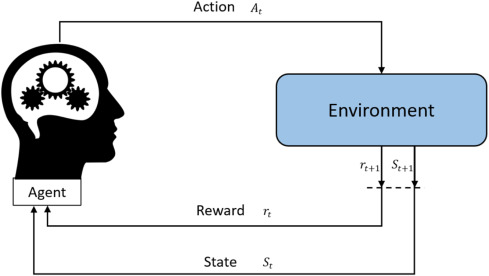

**The agent** here is what we directly control with action to interact with the environment which we can't directly control and the environment will feedback to the agent its current state and the reward for doing that action. We can simply denote it as
$$s0, a0, r0, s1, a1, r1, s2, a2, r2, s3, a3, r3,...$$

Which means at state s0 we interact with environment using action a0 and the environment will feedback us as reward r0 and let the agent coming to state s1.

**Markov Property:** each state depends only on its immediately previous state, which means state s2 depends only on state s1 (its previous state) and is independent of state s0.

# **What is policy?**
**Policy** can be denoted as 
$$\pi: s \to a$$
Which is a set of instructions to take action a at state s. It can also be denoted as 
$$\pi(a|s)$$
Which means we introduce some randomness into the policy for exploration. In this case, at state s there is a probability distribution over possible actions.

# **What is Total Cumulative Reward?**

The total cumulative reward, often shortened as **return**, is denoted as:

$$G_{t} = r_{t} + \gamma r_{t+1} + \gamma^2 r_{t+2} + \gamma^3 r_{t+3} + \dots$$

Where:
- $G_t$: the total cumulative reward from time step $t$.  
- $\gamma \in [0,1]$: the **discount factor**.  

We add $\gamma$ to the formula because the future is harder to predict, and we want to place more focus on immediate rewards.  
If we set $\gamma = 1$, the formula becomes the undiscounted sum, which maximizes the total reward over time. However, prioritizing higher immediate rewards may sometimes lead to worse outcomes in the future.


# **What is our goal in RL?**
**Our goal:** Find policy which maximizes our return

# **Grid example**

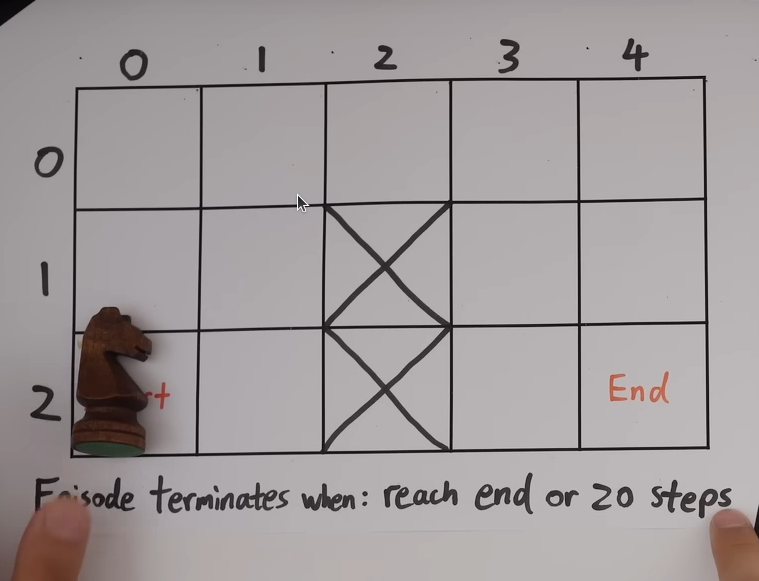

**State:** x, y coords

**Action:** a single number 0/1/2/3 (up/right/down/left)

**Reward:** 0 if reach target cell otherwise -1

# **What is world model?**
If our model knows what its state, action and reward after done that action, the action did unsuccessfully if reached obstacle, ... We call it **world model (model of environment)**. We can denote it as
$$ p: s,a \to s', r $$
$$ model: p(s',r|s,a) $$

# **What is model-free?**
Model-free means that our agent does not have access to our world model which means that the agent does not know what its state after doing an action for example at (0,0) agent chooses to do action 1 the agent did not know that it will end up at (1,0) in grid example above. So our agent need to maximizes the rewards it gets without access to any information or we can say that our agent need to improve the policy through many episodes during sampling process to maximize the rewards.

# **Define grid environment**

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import clear_output
from dataclasses import dataclass
import random
import numpy as np
import time
from tqdm import tqdm

@dataclass(frozen=True)
class Pos:
    x: int
    y: int

class MiniGridWorld:
    ACTIONS = {
        0: (0, -1),  # UP
        1: (0,  1),  # DOWN
        2: (-1, 0),  # LEFT
        3: (1,  0),  # RIGHT
    }

    def __init__(self,
                 start=Pos(0, 2),
                 goal=Pos(4, 2),
                 obstacles=None,
                 step_cost=-1.0,
                 goal_reward=0,
                 max_steps=20,
                 fps=5,
                 width = 5,
                 height = 3):
        if obstacles is None:
            obstacles = [Pos(2,1), Pos(2,2)]
        self.start = start
        self.goal = goal
        self.obstacles = set(obstacles)
        self.step_cost = step_cost
        self.goal_reward = goal_reward
        self.max_steps = max_steps
        self.fps = fps
        self.WIDTH = width
        self.HEIGHT = height
        self.reset()

    def reset(self):
        self.pos = Pos(self.start.x, self.start.y)
        self.steps = 0
        return self.pos

    def in_bounds(self, p: Pos) -> bool:
        return 0 <= p.x < self.WIDTH and 0 <= p.y < self.HEIGHT

    def is_blocked(self, p: Pos) -> bool:
        return p in self.obstacles

    def step(self, action: int):
        dx, dy = self.ACTIONS[action]
        candidate = Pos(self.pos.x + dx, self.pos.y + dy)
        if self.in_bounds(candidate) and not self.is_blocked(candidate):
            self.pos = candidate
        self.steps += 1
        if self.pos == self.goal:
            return self.pos, self.goal_reward, True, {}
        done = self.steps >= self.max_steps
        return self.pos, self.step_cost, done, {}

    def render_matplotlib(self):
        fig, ax = plt.subplots(figsize=(5,3))
        ax.set_xlim(0, self.WIDTH)
        ax.set_ylim(0, self.HEIGHT)
        ax.set_xticks(range(self.WIDTH+1))
        ax.set_yticks(range(self.HEIGHT+1))
        ax.grid(True)

        # Goal
        sx, sy = self.start.x, self.start.y
        start_rect = patches.Rectangle((sx, self.HEIGHT-1-sy), 1, 1,
                                      facecolor="orange", alpha=0.6)
        ax.add_patch(start_rect)
        
        # Obstacles
        for obs in self.obstacles:
            rect = patches.Rectangle((obs.x, self.HEIGHT-1-obs.y), 1, 1,
                                     facecolor="black", alpha=0.5)
            ax.add_patch(rect)

        # Goal
        gx, gy = self.goal.x, self.goal.y
        goal_rect = patches.Rectangle((gx, self.HEIGHT-1-gy), 1, 1,
                                      facecolor="green", alpha=0.6)
        ax.add_patch(goal_rect)

        # Agent
        ax.plot(self.pos.x+0.5, self.HEIGHT-1-self.pos.y+0.5,
                marker="o", color="blue", markersize=20)

        ax.set_xticklabels([])
        ax.set_yticklabels([])
        clear_output()
        plt.show()
        time.sleep(1/self.fps)

/home/dell/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


# **What is policy gradient method?**
Policy gradient method is a method that we calculate a change of the policy based on which actions are good and which actions are bad but to know that action is good or bad we need thing calls value functions.

# **What is value functions?**
This function keeps track of average return ($G_{t}$) expected when following a certain policy ($\pi$) in a certain state ($s$) or state + action ($s, a$) and help evaluate how good or bad states and actions are and can be denoted as
$$ \text{State-value } V_{\pi}(s)$$
$$ \text{Action-value } Q_{\pi}(s,a)$$
Action value function representing how much return we should expect if we are in a certain state pick a certain action and then following the given policy

**Best-case scenario (optimal)**
$$V_{*}(s) \quad Q_{*}(s,a)$$

**Value functions are deterministic (not random)**

# **How to improve the policy?**

There is **cyclic dependency** because the action value function usually based on policy function but now the policy function is also based on the action value function so with this cyclic nature as long as you keep improving the accuracy of the action value function, the policy will improve alongside it

**1) Policy gradient method**
* Issues with variance (different averages)
* More dependent on policy function

**2) Policy gradient method, with value funtion**
* Accounts for variance, which is good
* Balance of using policy & value function

**3) Just use action-value ($Q$) function**
* Policy becomes dependent of action-value function
* More dependent on value function

# **How to develop good value functions?**
We don't magically have access to an action value Q function so we need to develop one and make it more accurate overtime, the simplest way we can do this is just to take the trajectories we collected during sampling process and then average out the return values for each combination of state and action, so we develop a cheatsheet call Q table

# **Monte Carlo Method**

In [2]:
# Define epsilon-greedy method
def epsilon_greedy(Q_table, state, epsilon = 0.9):
    if random.random() < epsilon:
        return random.randint(0, 3)
    else:
        return np.argmax(Q_table[(state.x, state.y)])

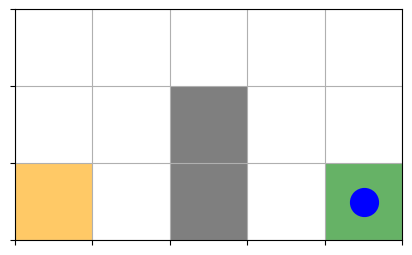

List of actions: [0, 3, 0, 3, 3, 1, 1, 3]


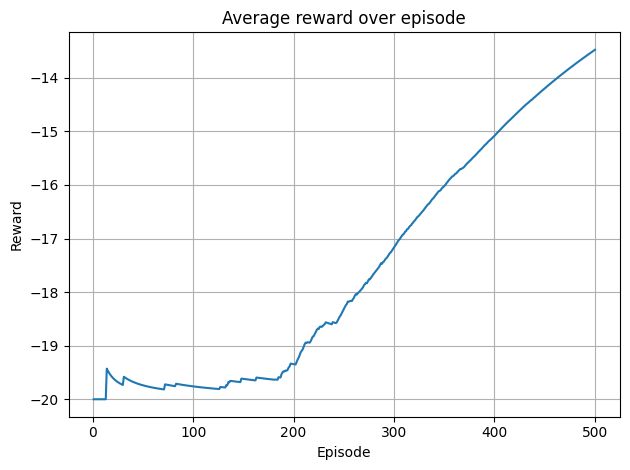

In [3]:
# --- Demo run ---
env = MiniGridWorld()

episodes = 500
Q_table = np.zeros((env.WIDTH, env.HEIGHT, len(env.ACTIONS)))
epsilon = 0.9
gamma = 0.8
lr = 0.1

reward_ovt = []
reward_arr = []

pbar = tqdm(range(episodes))

for episode in pbar:
    trajectory = []
    done = False
    if episode % 5 == 0:
        epsilon = max(0, epsilon - 0.01)
    state = env.reset()
    state = env.start
    rewards = 0
    while not done:
        action = epsilon_greedy(Q_table, state, epsilon)
        next_state, reward, done, _ = env.step(action)
        trajectory.append((state, action, reward))
        rewards += reward
        state = next_state
    G_t = 0
    for s, a, r in reversed(trajectory):
        G_t = r + gamma * G_t
        x, y = s.x, s.y
        Q_table[(x, y)][a] = Q_table[(x, y)][a] + (G_t - Q_table[(x, y)][a]) * lr
    reward_arr.append(rewards)
    reward_ovt.append(np.average(reward_arr))

    pbar.set_description(f"Episode {episode + 1}/{episodes} | Reward: {np.average(reward_arr):.2f} | "
          f"Epsilon: {epsilon:.3f}")

done = False
_ = env.reset()
env.render_matplotlib()
state = env.start
actions = []
while not done:
    action = np.argmax(Q_table[state.x, state.y])
    state, reward, done, _ = env.step(action)
    env.render_matplotlib()
    actions.append(action)

print("List of actions:", actions)

plt.figure()
plt.plot(np.arange(1, episodes + 1), np.array(reward_ovt), linewidth=1.5)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Average reward over episode")
plt.grid(True)
plt.tight_layout()
plt.show()
# print(reward_ovt)

# **Try with 8x5 Grid Problem and 8 obstacles**

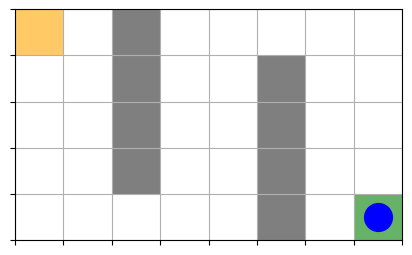

List of actions: [1, 1, 3, 1, 1, 3, 3, 0, 0, 0, 3, 0, 3, 3, 1, 3, 1, 1, 1]


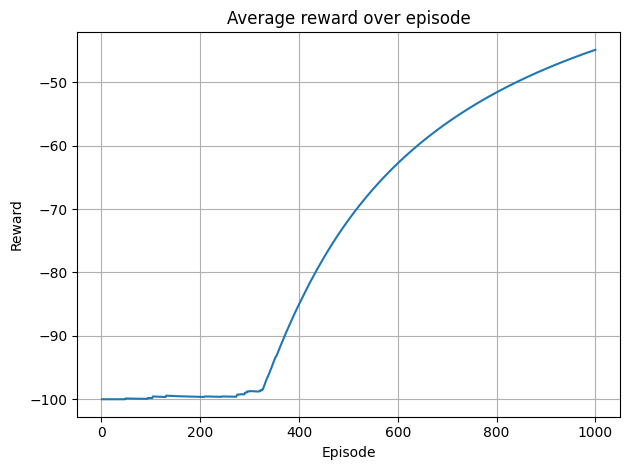

In [4]:
# --- Demo run ---
env = MiniGridWorld(start = Pos(0,0), goal = Pos(7,4), max_steps = 100, width = 8, height = 5, obstacles = [Pos(2, 0), Pos(2, 1), Pos(2, 2), Pos(2, 3), Pos(5, 1), Pos(5, 2), Pos(5, 3), Pos(5, 4)])

episodes = 1000
Q_table = np.zeros((env.WIDTH, env.HEIGHT, len(env.ACTIONS)))
epsilon = 0.9
gamma = 0.8
lr = 0.1

reward_ovt = []
reward_arr = []

pbar = tqdm(range(episodes))

for episode in pbar:
    trajectory = []
    done = False
    if episode % 5 == 0:
        epsilon = max(0, epsilon - 0.01)
    state = env.reset()
    state = env.start
    rewards = 0
    while not done:
        action = epsilon_greedy(Q_table, state, epsilon)
        next_state, reward, done, _ = env.step(action)
        trajectory.append((state, action, reward))
        rewards += reward
        state = next_state
    G_t = 0
    for s, a, r in reversed(trajectory):
        G_t = r + gamma * G_t
        x, y = s.x, s.y
        Q_table[(x, y)][a] = Q_table[(x, y)][a] + (G_t - Q_table[(x, y)][a]) * lr
    reward_arr.append(rewards)
    reward_ovt.append(np.average(reward_arr))

    pbar.set_description(f"Episode {episode + 1}/{episodes} | Reward: {np.average(reward_arr):.2f} | "
          f"Epsilon: {epsilon:.3f}")

done = False
_ = env.reset()
env.render_matplotlib()
state = env.start
actions = []
while not done:
    action = np.argmax(Q_table[state.x, state.y])
    state, reward, done, _ = env.step(action)
    env.render_matplotlib()
    actions.append(action)

print("List of actions:", actions)

plt.figure()
plt.plot(np.arange(1, episodes + 1), np.array(reward_ovt), linewidth=1.5)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Average reward over episode")
plt.grid(True)
plt.tight_layout()
plt.show()
# print(reward_ovt)

**Notice that**
While the Q funtion improves the policy functions improve too
$$ \text{approximating } Q_{\pi} \to \text{approximating } Q_{*} $$
$$ \text{policy } \pi \text{, based on Q, approaches }\pi_{*} \text{ (optimal policy)} $$
**Epsilon** maintains balance between exploration vs exploitation, at the start the agent needs to use random policy and achieve diverse experiences, once the agent actually want to perform better and get more reward known as exploitation then it just pick the highest value everytime so there is no randomness anymore, so the final probability distribution will be one action with 100% probability and the others is zero. When we deploy RL we want a balance between exploration and exploitation, we want to try things to improve and also take advantages from those improvements

**Policy gradient balance and epsilon greedy balance (Monte Carlo)**


**Disadvantages:** Monte Carlo needs to run full episode to calculate the Q table that may causes lack of resources if the episode get too long 

# **Credit assignment problem**
Figuring out the impact of an individual action, within a sequence of many actions. Which lead us to a concept known as temporal difference that breaks down the evaluation to an action by action based rather than episode by episode based. In temporal difference we are trying to construct an estimate of the returns, we do not directly calculate the returns by adding up all the subsequent rewards instead we come up with an estimate for each state action pair relative to the estimate for the state action pair in the timestep after it using just one reward as the difference not all the subsequent rewards. The terminate state at the end of episode which does not have a reward and next state afterwards stay at 0 acting as an anchor which the other values develop

$$G_{t} = r_{t} + \gamma r_{t+1} + \gamma^2 r_{t+2} + \gamma^3 r_{t+3} + \dots$$
$$G_{t} = r_{t} + \gamma (r_{t+1} + \gamma r_{t+2} + \gamma^2 r_{t+3} + \dots)$$
$$G_{t} = r_{t} + \gamma G_{t+1}$$

For more general average out estimate for state and action we can replace $G_{t}$ with $Q(s_{t}, a_{t})$ which denotes as

$$Q(s_{t}, a_{t}) \to r_{t} + \gamma Q(s_{t+1}, a_{t+1}) \quad \text{SARSA}$$
$$Q(s_{t}, a_{t}) \to r_{t} + \gamma \sum{\pi(a,s_{t+1})Q(s_{t+1}, a_{t})} \quad \text{Expected SARSA}$$
$$Q(s_{t}, a_{t}) \to r_{t} + \gamma \underset{a}{max}Q(s_{t+1},a) \quad \text{Q-Learning}$$

Due to the randomness of the environment this might not be the only subsequent state that is possible and since there is a range of different actions we can take this also not the only subsequent action that is possible, but we can not do much about the state because we are talking about model-free method so our agent does not have access to world model

For any given state and action
* **Monte Carlo** is saying what is my return
* **SARSA** is saying how much better or worse is my return relative to the new state and the action that we ended up taking
* **Expected SARSA** is saying how much better or worse is my return relative to the new state with all of its action averaged out according to policy probabilities
* **Q-Learning** is saying how much better or worse is my return relative to the new state with its best case scenario highest estimated action

We can also learn the state value V instead of learning the action value Q function where it is a bit simpler because it only takes state oppose to state and action but not in this notebook
$$V(s_{t}) \to r_{t} + \gamma V(s_{t+1})$$

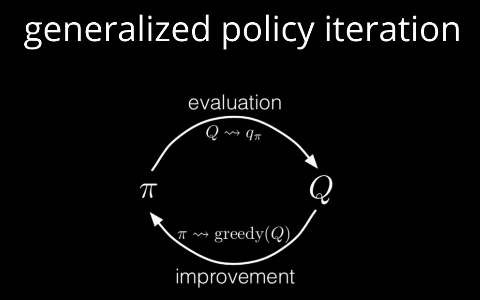

# **Learning action-value (Q) function**
$$ Q(s_{t},a_{t}) \gets Q(s_{t},a_{t}) + \alpha [r_{t} + \gamma Q(s_{t+1},a_{t+1}) - Q(s_{t},a_{t})] \quad \text{SARSA}$$
$$ Q(s_{t},a_{t}) \gets Q(s_{t},a_{t}) + \alpha [r_{t} + \gamma \sum{\pi(a,s_{t+1})Q(s_{t+1}, a_{t})} - Q(s_{t},a_{t})] \quad \text{Expected SARSA}$$
$$ Q(s_{t},a_{t}) \gets Q(s_{t},a_{t}) + \alpha [r_{t} + \gamma \underset{a}{max}Q(s_{t+1},a) - Q(s_{t},a_{t})] \quad \text{Q-Learning}$$

# **What is on-policy method?**
On-policy method where the behavior policy (policy used  gather experiences) is the same as the target policy (policy that is being evaluated or improved)
$$ \text{Behavior policy = Target policy} $$ 
These methods are SARSA, Expected SARSA, ...

# **What is off-policy method?**
Off-policy method where the behavior policy is not the same as the target policy it still the policy $\pi$ to gather experiences but it is not trying to evaluate the policy $\pi$ it is instead trying to evaluate the optimal policy directly
$$ \text{Behavior policy $\neq$ Target policy} $$ 
These methods are Q-Learning, ...

# **What is the difference?**
These methods differ in their sample efficiency to get good at a task

# **Q-Learning**
Develop a function $Q$ to approximate $Q_{*}$ by updating:
$$ Q(s_{t},a_{t}) \to r_{t} + \gamma \underset{a}{max}Q(s_{t+1},a) $$
Equation that describes what $Q_{*}$ is actually supposed to be:
$$ Q_{*}(s_{t},a_{t}) = \mathbb{E}[r_{t} + \gamma \underset{a}{max}Q(s_{t+1},a)] \quad \text{Bellman Optimality Equation}$$
**Environment is random (many possible next states/rewards)**
$$ \text{according to world model: } \enclose{horizontalstrike}{p(s_{t},r|s,a)} \text{ which we do not have access to}$$
$$ \text{Expected value = weighted average according to probabilities and this is the result of samples averaging out during sampling process} $$

# **Bellman's priciple of optimality**
For simply understanding what Bellman Optimality Equation is, in dynamic programming method breaks decision problem into smaller subproblems and Bellman's principle of optimality says that to have optimal result in the problem we must have optimal result in the subproblems that broke down from the problem.

Example: to have full marks in an exam, we must have full marks in task 1, task 2, ... in an exam

# **Q-Learning Method**

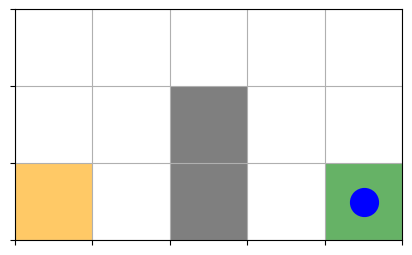

List of actions: [0, 3, 0, 3, 3, 3, 1, 1]


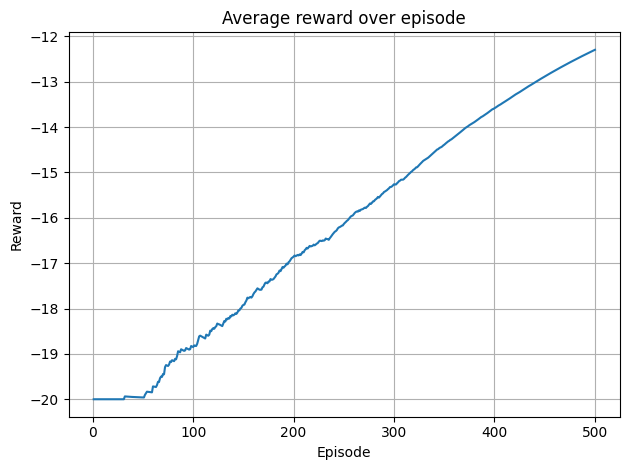

In [5]:
# --- Demo run ---
env = MiniGridWorld()

episodes = 500
Q_table = np.zeros((env.WIDTH, env.HEIGHT, len(env.ACTIONS)))
epsilon = 0.9
gamma = 0.8
lr = 0.1

reward_ovt = []
reward_arr = []

pbar = tqdm(range(episodes))

for episode in pbar:
    done = False
    if episode % 5 == 0:
        epsilon = max(0, epsilon - 0.01)
    state = env.reset()
    state = env.start
    rewards = 0
    while not done:
        action = epsilon_greedy(Q_table, state, epsilon)
        next_state, reward, done, _ = env.step(action)
        max_next_q = np.max(Q_table[next_state.x, next_state.y])
        Q_table[state.x, state.y][action] += lr * (reward + gamma * max_next_q - Q_table[state.x, state.y][action])
        rewards += reward
        state = next_state
    reward_arr.append(rewards)
    reward_ovt.append(np.average(reward_arr))

    pbar.set_description(f"Episode {episode + 1}/{episodes} | Reward: {np.average(reward_arr):.2f} | "
          f"Epsilon: {epsilon:.3f}")

done = False
_ = env.reset()
env.render_matplotlib()
state = env.start
actions = []
while not done:
    action = np.argmax(Q_table[state.x, state.y])
    state, reward, done, _ = env.step(action)
    env.render_matplotlib()
    actions.append(action)

print("List of actions:", actions)

plt.figure()
plt.plot(np.arange(1, episodes + 1), np.array(reward_ovt), linewidth=1.5)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Average reward over episode")
plt.grid(True)
plt.tight_layout()
plt.show()
# print(reward_ovt)

# **Try with 8x5 Grid Problem and 8 obstacles**

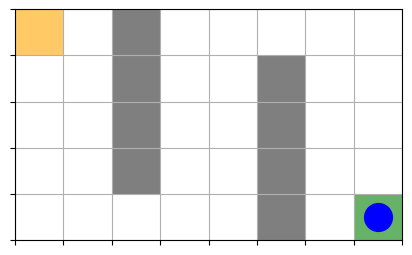

List of actions: [1, 3, 1, 1, 1, 3, 3, 0, 0, 3, 0, 0, 3, 3, 1, 1, 1, 1, 3]


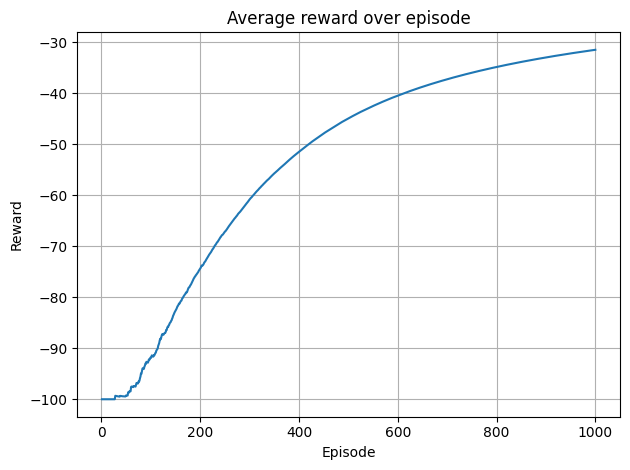

In [6]:
# --- Demo run ---
env = MiniGridWorld(start = Pos(0,0), goal = Pos(7,4), max_steps = 100, width = 8, height = 5, obstacles = [Pos(2, 0), Pos(2, 1), Pos(2, 2), Pos(2, 3), Pos(5, 1), Pos(5, 2), Pos(5, 3), Pos(5, 4)])

episodes = 1000
Q_table = np.zeros((env.WIDTH, env.HEIGHT, len(env.ACTIONS)))
epsilon = 0.9
gamma = 0.8
lr = 0.1

reward_ovt = []
reward_arr = []

pbar = tqdm(range(episodes))

for episode in pbar:
    done = False
    if episode % 5 == 0:
        epsilon = max(0, epsilon - 0.01)
    state = env.reset()
    state = env.start
    rewards = 0
    while not done:
        action = epsilon_greedy(Q_table, state, epsilon)
        next_state, reward, done, _ = env.step(action)
        max_next_q = np.max(Q_table[next_state.x, next_state.y])
        Q_table[state.x, state.y][action] += lr * (reward + gamma * max_next_q - Q_table[state.x, state.y][action])
        rewards += reward
        state = next_state
    reward_arr.append(rewards)
    reward_ovt.append(np.average(reward_arr))

    pbar.set_description(f"Episode {episode + 1}/{episodes} | Reward: {np.average(reward_arr):.2f} | "
          f"Epsilon: {epsilon:.3f}")

done = False
_ = env.reset()
env.render_matplotlib()
state = env.start
actions = []
while not done:
    action = np.argmax(Q_table[state.x, state.y])
    state, reward, done, _ = env.step(action)
    env.render_matplotlib()
    actions.append(action)

print("List of actions:", actions)

plt.figure()
plt.plot(np.arange(1, episodes + 1), np.array(reward_ovt), linewidth=1.5)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Average reward over episode")
plt.grid(True)
plt.tight_layout()
plt.show()
# print(reward_ovt)

# **SARSA Method**

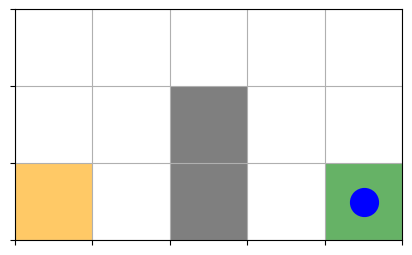

List of actions: [3, 0, 0, 3, 3, 1, 1, 3]


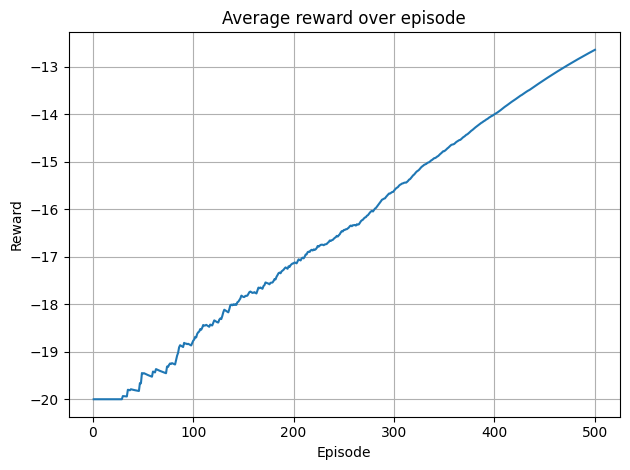

In [7]:
# --- Demo run ---
env = MiniGridWorld()

episodes = 500
Q_table = np.zeros((env.WIDTH, env.HEIGHT, len(env.ACTIONS)))
epsilon = 0.9
gamma = 0.8
lr = 0.1

reward_ovt = []
reward_arr = []

pbar = tqdm(range(episodes))

for episode in pbar:
    done = False
    if episode % 5 == 0:
        epsilon = max(0, epsilon - 0.01)
    state = env.reset()
    state = env.start
    rewards = 0
    while not done:
        action = epsilon_greedy(Q_table, state, epsilon)
        next_state, reward, done, _ = env.step(action)
        next_action = epsilon_greedy(Q_table, next_state, epsilon)
        next_q = Q_table[next_state.x, next_state.y][next_action]
        td_target = reward + gamma * next_q
        td_error = td_target - Q_table[state.x, state.y][action]
        Q_table[state.x, state.y][action] += lr * td_error
        rewards += reward
        state = next_state
    reward_arr.append(rewards)
    reward_ovt.append(np.average(reward_arr))

    pbar.set_description(f"Episode {episode + 1}/{episodes} | Reward: {np.average(reward_arr):.2f} | "
          f"Epsilon: {epsilon:.3f}")

done = False
_ = env.reset()
env.render_matplotlib()
state = env.start
actions = []
while not done:
    action = np.argmax(Q_table[state.x, state.y])
    state, reward, done, _ = env.step(action)
    env.render_matplotlib()
    actions.append(action)

print("List of actions:", actions)

plt.figure()
plt.plot(np.arange(1, episodes + 1), np.array(reward_ovt), linewidth=1.5)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Average reward over episode")
plt.grid(True)
plt.tight_layout()
plt.show()
# print(reward_ovt)

# **Try with 8x5 Grid Problem and 8 obstacles**

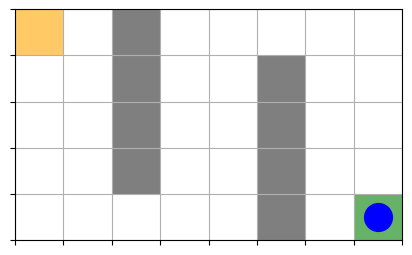

List of actions: [1, 1, 1, 3, 1, 3, 3, 0, 0, 0, 0, 3, 3, 3, 1, 1, 1, 1, 3]


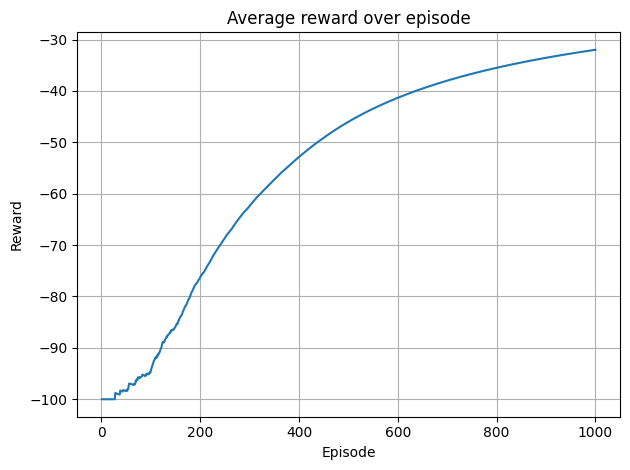

In [8]:
# --- Demo run ---
env = MiniGridWorld(start = Pos(0,0), goal = Pos(7,4), max_steps = 100, width = 8, height = 5, obstacles = [Pos(2, 0), Pos(2, 1), Pos(2, 2), Pos(2, 3), Pos(5, 1), Pos(5, 2), Pos(5, 3), Pos(5, 4)])

episodes = 1000
Q_table = np.zeros((env.WIDTH, env.HEIGHT, len(env.ACTIONS)))
epsilon = 0.9
gamma = 0.8
lr = 0.1

reward_ovt = []
reward_arr = []

pbar = tqdm(range(episodes))

for episode in pbar:
    done = False
    if episode % 5 == 0:
        epsilon = max(0, epsilon - 0.01)
    state = env.reset()
    state = env.start
    rewards = 0
    while not done:
        action = epsilon_greedy(Q_table, state, epsilon)
        next_state, reward, done, _ = env.step(action)
        next_action = epsilon_greedy(Q_table, next_state, epsilon)
        next_q = Q_table[next_state.x, next_state.y][next_action]
        td_target = reward + gamma * next_q
        td_error = td_target - Q_table[state.x, state.y][action]
        Q_table[state.x, state.y][action] += lr * td_error
        rewards += reward
        state = next_state
    reward_arr.append(rewards)
    reward_ovt.append(np.average(reward_arr))

    pbar.set_description(f"Episode {episode + 1}/{episodes} | Reward: {np.average(reward_arr):.2f} | "
          f"Epsilon: {epsilon:.3f}")

done = False
_ = env.reset()
env.render_matplotlib()
state = env.start
actions = []
while not done:
    action = np.argmax(Q_table[state.x, state.y])
    state, reward, done, _ = env.step(action)
    env.render_matplotlib()
    actions.append(action)

print("List of actions:", actions)

plt.figure()
plt.plot(np.arange(1, episodes + 1), np.array(reward_ovt), linewidth=1.5)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Average reward over episode")
plt.grid(True)
plt.tight_layout()
plt.show()
# print(reward_ovt)

# **Expected SARSA Method**

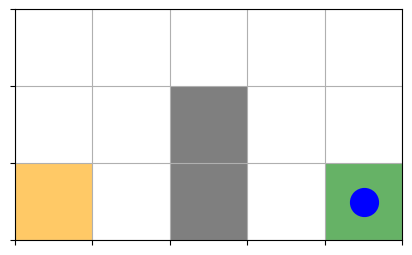

List of actions: [0, 0, 3, 3, 3, 1, 1, 3]


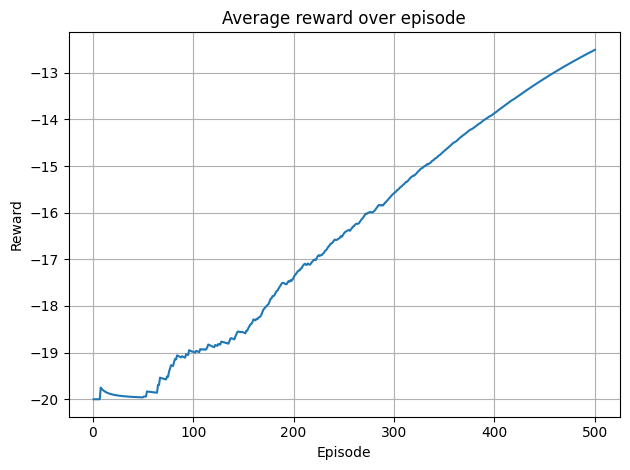

In [9]:
# --- Demo run ---
env = MiniGridWorld()

episodes = 500
Q_table = np.zeros((env.WIDTH, env.HEIGHT, len(env.ACTIONS)))
epsilon = 0.9
gamma = 0.8
lr = 0.1

reward_ovt = []
reward_arr = []

pbar = tqdm(range(episodes))

for episode in pbar:
    done = False
    if episode % 5 == 0:
        epsilon = max(0, epsilon - 0.01)
    state = env.reset()
    state = env.start
    rewards = 0
    while not done:
        action = epsilon_greedy(Q_table, state, epsilon)
        next_state, reward, done, _ = env.step(action)
        expected_q_next = 0.0
        if not done:
            q_values_next_state = Q_table[next_state.x, next_state.y]
            max_q_next = np.max(q_values_next_state)
            # Identify all actions with the maximum Q-value (greedy actions)
            greedy_actions = [a for a, q in enumerate(q_values_next_state) if q == max_q_next]
            num_actions = len(env.ACTIONS)
            num_greedy_actions = len(greedy_actions)
            prob_greedy = (1.0 - epsilon) / num_greedy_actions + epsilon / num_actions
            prob_non_greedy = epsilon / num_actions
            # Compute the expected Q-value for the next state
            for a_prime in env.ACTIONS:
                q_s_prime_a_prime = q_values_next_state[a_prime]
                if a_prime in greedy_actions:
                    expected_q_next += prob_greedy * q_s_prime_a_prime
                else:
                    expected_q_next += prob_non_greedy * q_s_prime_a_prime
        td_target = reward + gamma * expected_q_next
        td_error = td_target - Q_table[state.x, state.y][action]
        Q_table[state.x, state.y][action] += lr * td_error
        rewards += reward
        state = next_state
    reward_arr.append(rewards)
    reward_ovt.append(np.average(reward_arr))

    pbar.set_description(f"Episode {episode + 1}/{episodes} | Reward: {np.average(reward_arr):.2f} | "
          f"Epsilon: {epsilon:.3f}")

done = False
_ = env.reset()
env.render_matplotlib()
state = env.start
actions = []
while not done:
    action = np.argmax(Q_table[state.x, state.y])
    state, reward, done, _ = env.step(action)
    env.render_matplotlib()
    actions.append(action)

print("List of actions:", actions)

plt.figure()
plt.plot(np.arange(1, episodes + 1), np.array(reward_ovt), linewidth=1.5)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Average reward over episode")
plt.grid(True)
plt.tight_layout()
plt.show()
# print(reward_ovt)

# **Try with 8x5 Grid Problem and 8 obstacles**

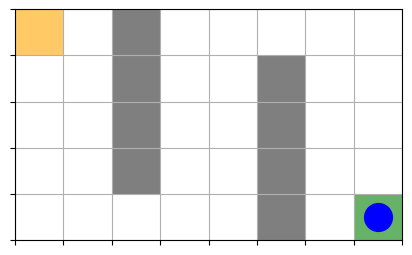

List of actions: [1, 1, 1, 3, 1, 3, 3, 0, 0, 0, 0, 3, 3, 3, 1, 1, 1, 1, 3]


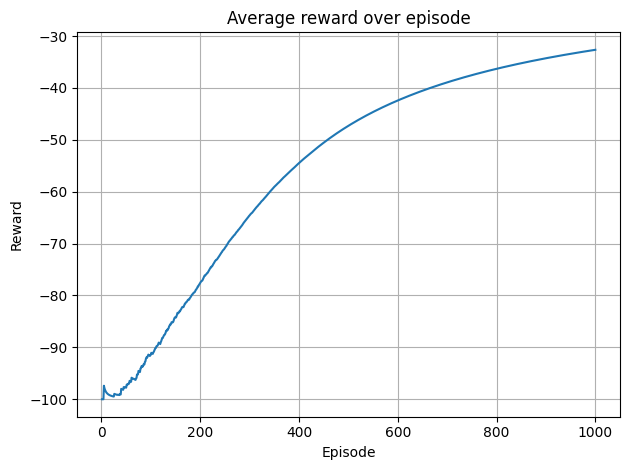

In [10]:
# --- Demo run ---
env = MiniGridWorld(start = Pos(0,0), goal = Pos(7,4), max_steps = 100, width = 8, height = 5, obstacles = [Pos(2, 0), Pos(2, 1), Pos(2, 2), Pos(2, 3), Pos(5, 1), Pos(5, 2), Pos(5, 3), Pos(5, 4)])

episodes = 1000
Q_table = np.zeros((env.WIDTH, env.HEIGHT, len(env.ACTIONS)))
epsilon = 0.9
gamma = 0.8
lr = 0.1

reward_ovt = []
reward_arr = []

pbar = tqdm(range(episodes))

for episode in pbar:
    done = False
    if episode % 5 == 0:
        epsilon = max(0, epsilon - 0.01)
    state = env.reset()
    state = env.start
    rewards = 0
    while not done:
        action = epsilon_greedy(Q_table, state, epsilon)
        next_state, reward, done, _ = env.step(action)
        expected_q_next = 0.0
        if not done:
            q_values_next_state = Q_table[next_state.x, next_state.y]
            max_q_next = np.max(q_values_next_state)
            # Identify all actions with the maximum Q-value (greedy actions)
            greedy_actions = [a for a, q in enumerate(q_values_next_state) if q == max_q_next]
            num_actions = len(env.ACTIONS)
            num_greedy_actions = len(greedy_actions)
            prob_greedy = (1.0 - epsilon) / num_greedy_actions + epsilon / num_actions
            prob_non_greedy = epsilon / num_actions
            # Compute the expected Q-value for the next state
            for a_prime in env.ACTIONS:
                q_s_prime_a_prime = q_values_next_state[a_prime]
                if a_prime in greedy_actions:
                    expected_q_next += prob_greedy * q_s_prime_a_prime
                else:
                    expected_q_next += prob_non_greedy * q_s_prime_a_prime
        td_target = reward + gamma * expected_q_next
        td_error = td_target - Q_table[state.x, state.y][action]
        Q_table[state.x, state.y][action] += lr * td_error
        rewards += reward
        state = next_state
    reward_arr.append(rewards)
    reward_ovt.append(np.average(reward_arr))

    pbar.set_description(f"Episode {episode + 1}/{episodes} | Reward: {np.average(reward_arr):.2f} | "
          f"Epsilon: {epsilon:.3f}")

done = False
_ = env.reset()
env.render_matplotlib()
state = env.start
actions = []
while not done:
    action = np.argmax(Q_table[state.x, state.y])
    state, reward, done, _ = env.step(action)
    env.render_matplotlib()
    actions.append(action)

print("List of actions:", actions)

plt.figure()
plt.plot(np.arange(1, episodes + 1), np.array(reward_ovt), linewidth=1.5)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Average reward over episode")
plt.grid(True)
plt.tight_layout()
plt.show()
# print(reward_ovt)

# **Deep Q Network**
Deep neural network help us to convert discrete state and action space to continuous state and action space. And it will replace Q_table with Deep_Q_Network, but DQN only convert discrete state space to continuous state space and not convert action space, action space still discrete.

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
# Define the Policy Network (Actor)
class DeepQNetwork(nn.Module):
    """ MLP Actor network for PPO """
    def __init__(self, n_observations=2, n_actions=4):
        super(DeepQNetwork, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.relu1 = nn.PReLU(128)
        self.layer2 = nn.Linear(128, 128)
        self.relu2 = nn.PReLU(128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the network.

        Parameters:
        - x (torch.Tensor): Input tensor representing the state(s).

        Returns:
        - torch.Tensor: Output tensor representing Q-values for each action.
        """
        # Ensure input is float tensor
        if not isinstance(x, torch.Tensor):
             x = torch.tensor(x, dtype=torch.float32, device=device)
        elif x.dtype != torch.float32:
             x = x.to(dtype=torch.float32)

        # Apply layers with ReLU activation
        x = self.layer1(x)
        x = self.relu1(x)
        x = self.layer2(x)
        x = self.relu2(x)
        return self.layer3(x) # Output layer has no activation (raw Q-values)

In [12]:
# ======================
# Replay Buffer
# ======================
from collections import deque
class ReplayBuffer:
    def __init__(self, capacity: int):
        self.buf = deque(maxlen=capacity)

    def push(self, s, a, r, s_next, done):
        # Lưu dạng (np.array, int, float, np.array, bool)
        self.buf.append((s, a, r, s_next, done))

    def sample(self, batch_size: int):
        batch = random.sample(self.buf, batch_size)
        s, a, r, s_next, d = map(np.array, zip(*batch))
        # chuyển về tensor
        s      = torch.tensor(s, dtype=torch.float32, device=device)
        a      = torch.tensor(a, dtype=torch.int64,   device=device).unsqueeze(-1)
        r      = torch.tensor(r, dtype=torch.float32, device=device).unsqueeze(-1)
        s_next = torch.tensor(s_next, dtype=torch.float32, device=device)
        d      = torch.tensor(d.astype(np.float32), dtype=torch.float32, device=device).unsqueeze(-1)
        return s, a, r, s_next, d

    def __len__(self):
        return len(self.buf)

In [13]:
# ======================
# Helper: epsilon schedule & state encoding
# ======================
def state_to_tensor(state, env) -> np.ndarray:
    """
    Encode state -> vector float (2 chiều)
    Giả định state có .x và .y; scale về [0,1] để dễ học.
    """
    # Nếu env trả về dạng khác, điều chỉnh tại đây.
    x = getattr(state, "x", None)
    y = getattr(state, "y", None)
    if x is None or y is None:
        # fallback: nếu state đã là mảng/ndarray
        arr = np.array(state, dtype=np.float32).reshape(-1)
        return arr
    return np.array([x / max(1, env.WIDTH - 1), y / max(1, env.HEIGHT - 1)], dtype=np.float32)

def select_action(policy_net, state_vec: np.ndarray, epsilon: float, n_actions: int) -> int:
    if random.random() < epsilon:
        return random.randrange(n_actions)
    with torch.no_grad():
        q = policy_net(state_vec[None, :])  # shape [1, n_actions]
        return int(q.argmax(dim=1).item())

def train_step(policy_net, target_net, optimizer, replay: ReplayBuffer, batch_size: int = 64, gamma: float = 0.8, grad_clip_norm: float = 10.0):
    if len(replay) < batch_size:
        return None

    s, a, r, s_next, d = replay.sample(batch_size)

    # Q(s,a) hiện tại
    q_values = policy_net(s)                      # [B, A]
    q_sa = torch.gather(q_values, dim=1, index=a) # [B, 1]

    # y = r + gamma * max_a' Q_target(s', a') * (1 - done)
    with torch.no_grad():
        q_next = target_net(s_next)               # [B, A]
        max_q_next, _ = q_next.max(dim=1, keepdim=True)  # [B, 1]
        target = r + (1.0 - d) * gamma * max_q_next

    loss = F.mse_loss(q_sa, target)

    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    if grad_clip_norm is not None:
        nn.utils.clip_grad_norm_(policy_net.parameters(), grad_clip_norm)
    optimizer.step()

    return float(loss.item())

In [14]:
def reward_func(state, final_state):
    return np.sqrt((final_state.x - state.x)**2 + (final_state.y - state.y)**2)

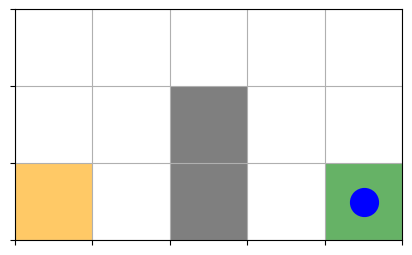

List of actions: [0, 0, 3, 3, 3, 3, 1, 1]


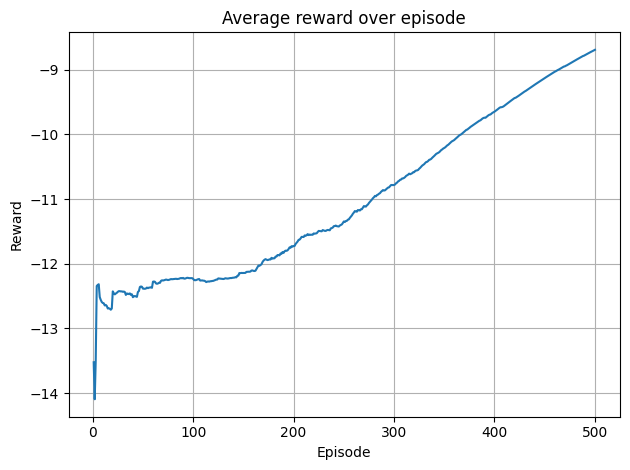

In [15]:
# --- Demo run ---
env = MiniGridWorld()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

n_actions = len(env.ACTIONS)
obs_dim = 2

policy_net = DeepQNetwork(n_observations=obs_dim, n_actions=n_actions).to(device)
target_net = DeepQNetwork(n_observations=obs_dim, n_actions=n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=0.002)
replay = ReplayBuffer(10000)

TARGET_UPDATE_FREQ = 20
episodes = 500
epsilon = 0.9
gamma = 0.8
batch_size = 128
global_step = 0

reward_ovt = []
reward_arr = []

pbar = tqdm(range(episodes))

for episode in pbar:
    done = False
    if episode % 5 == 0:
        epsilon = max(0, epsilon - 0.01)
    state = env.reset()
    state = env.start
    rewards = 0
    while not done:
        s_vec = state_to_tensor(state, env)
        action = select_action(policy_net, s_vec, epsilon, n_actions)
        next_state, reward, done, _ = env.step(action)
        reward += 0.1*reward_func(state, env.goal)
        s_next_vec = state_to_tensor(next_state, env)
        replay.push(s_vec, action, reward, s_next_vec, done)
        loss_val = None
        if episode >= 20:
            loss_val = train_step(policy_net, target_net, optimizer, replay, gamma = gamma, batch_size = batch_size)
        rewards += reward
        state = next_state
        
    # Hard update target
    if global_step % TARGET_UPDATE_FREQ == 0:
        target_net.load_state_dict(policy_net.state_dict())
    global_step += 1
    reward_arr.append(rewards)
    reward_ovt.append(np.average(reward_arr))

    if loss_val is not None:
        pbar.set_description(f"Episode {episode + 1}/{episodes} | Reward: {np.average(reward_arr):.2f} | "
              f"Epsilon: {epsilon:.3f} | Steps: {global_step} | Loss: {loss_val:.3f}")
    else:
        pbar.set_description(f"Warmup Episode {episode + 1}/{episodes} | Reward: {np.average(reward_arr):.2f} | "
              f"Epsilon: {epsilon:.3f} | Steps: {global_step}")

done = False
_ = env.reset()
env.render_matplotlib()
state = env.start
actions = []
while not done:
    s_vec = state_to_tensor(state, env)
    with torch.no_grad():
        q = policy_net(s_vec[None, :])
        action = int(q.argmax(dim=1).item())
    state, reward, done, _ = env.step(action)
    env.render_matplotlib()
    actions.append(action)

print("List of actions:", actions)

plt.figure()
plt.plot(np.arange(1, episodes + 1), np.array(reward_ovt), linewidth=1.5)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Average reward over episode")
plt.grid(True)
plt.tight_layout()
plt.show()
# print(reward_ovt)

# **Try with 8x5 Grid Problem and 8 obstacles**

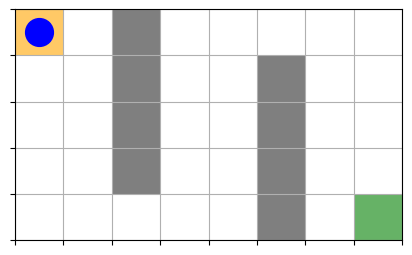

List of actions: [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]


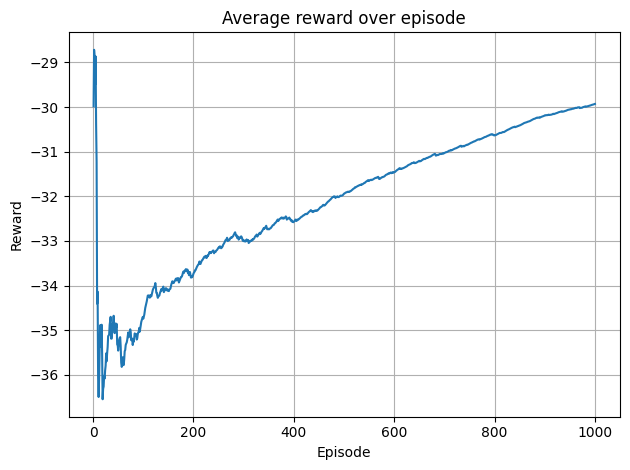

In [16]:
# --- Demo run ---
env = MiniGridWorld(start = Pos(0,0), goal = Pos(7,4), max_steps = 100, width = 8, height = 5, obstacles = [Pos(2, 0), Pos(2, 1), Pos(2, 2), Pos(2, 3), Pos(5, 1), Pos(5, 2), Pos(5, 3), Pos(5, 4)])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

n_actions = len(env.ACTIONS)
obs_dim = 2

policy_net = DeepQNetwork(n_observations=obs_dim, n_actions=n_actions).to(device)
target_net = DeepQNetwork(n_observations=obs_dim, n_actions=n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=0.01)
replay = ReplayBuffer(10000)

TARGET_UPDATE_FREQ = 50
episodes = 1000
epsilon = 0.99
gamma = 0.99
batch_size = 128
global_step = 0

reward_ovt = []
reward_arr = []

pbar = tqdm(range(episodes))

for episode in pbar:
    done = False
    if episode % 50 == 0:
        epsilon = max(0, epsilon - 0.01)
    state = env.reset()
    state = env.start
    rewards = 0
    while not done:
        s_vec = state_to_tensor(state, env)
        action = select_action(policy_net, s_vec, epsilon, n_actions)
        next_state, reward, done, _ = env.step(action)
        reward += 0.1*reward_func(state, env.goal)
        s_next_vec = state_to_tensor(next_state, env)
        replay.push(s_vec, action, reward, s_next_vec, done)
        loss_val = None
        if episode >= 20:
            loss_val = train_step(policy_net, target_net, optimizer, replay, gamma = gamma, batch_size = batch_size)
        rewards += reward
        state = next_state
        
    # Hard update target
    if global_step % TARGET_UPDATE_FREQ == 0:
        target_net.load_state_dict(policy_net.state_dict())
    global_step += 1
    reward_arr.append(rewards)
    reward_ovt.append(np.average(reward_arr))

    if loss_val is not None:
        pbar.set_description(f"Episode {episode + 1}/{episodes} | Reward: {np.average(reward_arr):.2f} | "
              f"Epsilon: {epsilon:.3f} | Steps: {global_step} | Loss: {loss_val:.3f}")
    else:
        pbar.set_description(f"Warmup Episode {episode + 1}/{episodes} | Reward: {np.average(reward_arr):.2f} | "
              f"Epsilon: {epsilon:.3f} | Steps: {global_step}")

done = False
_ = env.reset()
env.render_matplotlib()
state = env.start
actions = []
while not done:
    s_vec = state_to_tensor(state, env)
    with torch.no_grad():
        q = policy_net(s_vec[None, :])
        action = int(q.argmax(dim=1).item())
    state, reward, done, _ = env.step(action)
    env.render_matplotlib()
    actions.append(action)

print("List of actions:", actions)

plt.figure()
plt.plot(np.arange(1, episodes + 1), np.array(reward_ovt), linewidth=1.5)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Average reward over episode")
plt.grid(True)
plt.tight_layout()
plt.show()
# print(reward_ovt)

# **What is actor-critic?**
Actor is the policy $\pi$ to choose action a at state s and Critic is to evaluate the action that actor has chosen. Like in DQN, SARSA, Expected SARSA, Q-Learning, Monte Carlo, the actor is epsilon greedy and choose action exact from Q_table or Q_network. Critic is different between those methods of course.

So in actor-critic methods we focus in develop a actor function to choose action and critic function to evaluate it not like value based just develop critic function

# **Actor-Critic method (A2C)**

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
# Define the Policy Network (Actor)
class ActorNetwork(nn.Module):
    """ MLP Actor network for PPO """
    def __init__(self, n_observations=2, n_actions=4):
        super(ActorNetwork, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.relu1 = nn.Tanh()
        self.layer2 = nn.Linear(128, 128)
        self.relu2 = nn.Tanh()
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the network.

        Parameters:
        - x (torch.Tensor): Input tensor representing the state(s).

        Returns:
        - torch.Tensor: Output tensor representing Q-values for each action.
        """
        # Ensure input is float tensor
        if not isinstance(x, torch.Tensor):
             x = torch.tensor(x, dtype=torch.float32, device=device)
        elif x.dtype != torch.float32:
             x = x.to(dtype=torch.float32)

        # Apply layers with ReLU activation
        x = self.layer1(x)
        x = self.relu1(x)
        x = self.layer2(x)
        x = self.relu2(x)
        return self.layer3(x) # Output layer has no activation (raw Q-values)

class CriticNetwork(nn.Module):
    """ MLP Actor network for PPO """
    def __init__(self, n_observations=2):
        super(CriticNetwork, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.relu1 = nn.Tanh()
        self.layer2 = nn.Linear(128, 128)
        self.relu2 = nn.Tanh()
        self.layer3 = nn.Linear(128, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the network.

        Parameters:
        - x (torch.Tensor): Input tensor representing the state(s).

        Returns:
        - torch.Tensor: Output tensor representing Q-values for each action.
        """
        # Ensure input is float tensor
        if not isinstance(x, torch.Tensor):
             x = torch.tensor(x, dtype=torch.float32, device=device)
        elif x.dtype != torch.float32:
             x = x.to(dtype=torch.float32)

        # Apply layers with ReLU activation
        x = self.layer1(x)
        x = self.relu1(x)
        x = self.layer2(x)
        x = self.relu2(x)
        return self.layer3(x) # Output layer has no activation (raw Q-values)

In [39]:
@torch.no_grad()
def _td_target(critic, s_next, r, d, gamma):
    """
    TD target: y = r + gamma * (1 - done) * V(s')
    Inputs:
      - critic(s_next): [B, 1]
      - r, d: [B, 1] float
    Returns: [B] float
    """
    v_next = critic(s_next).squeeze(1)                  # [B]
    y = r.squeeze(1) + gamma * (1.0 - d.squeeze(1)) * v_next
    return y                                            # [B]


def train_step_actor_critic(
    actor, critic,
    opt_actor, opt_critic,
    replay,                           # ReplayBuffer: sample(batch_size, device)
    batch_size: int = 64,
    gamma: float = 0.99,
    entropy_coef: float = 0.01,
    value_coef: float = 0.5,
    grad_clip_norm: float = 10.0,
    device=None,
):
    """
    A2C-style update:
      - Advantage A = y - V(s)
      - Actor loss   = -E[ log pi(a|s) * A ] - entropy_coef * H(pi)
      - Critic loss  = MSE( V(s), y )
      - Total        = Actor + value_coef * Critic
    """

    if len(replay) < batch_size:
        return None

    s, a, r, s_next, d = replay.sample(batch_size)  # shapes:
    # s: [B,obs], a:[B,1] long, r:[B,1] float, s_next:[B,obs], d:[B,1] float

    # ----- Critic -----
    v_s = critic(s).squeeze(1)                     # [B]
    y   = _td_target(critic, s_next, r, d, gamma)  # [B]
    advantage = y - v_s                            # [B]

    critic_loss = F.mse_loss(v_s, y)               # scalar

    opt_critic.zero_grad(set_to_none=True)
    critic_loss *= value_coef
    critic_loss.backward()
    if grad_clip_norm is not None:
        nn.utils.clip_grad_norm_(critic.parameters(), grad_clip_norm)
    opt_critic.step()

    # ----- Actor -----
    # logits -> log_probs
    logits = actor(s)                              # [B, A]
    log_probs = F.log_softmax(logits, dim=1)       # [B, A]
    # chọn log-prob của action đã thực hiện
    log_pi_a = log_probs.gather(1, a).squeeze(1)   # [B]

    # Entropy (khuyến khích khám phá)
    probs = log_probs.exp()
    entropy = -(probs * log_probs).sum(dim=1).mean()  # scalar

    # detach advantage khi update actor
    actor_loss = -(log_pi_a * advantage.detach()).mean() - entropy_coef * entropy

    opt_actor.zero_grad(set_to_none=True)
    actor_loss.backward()
    if grad_clip_norm is not None:
        nn.utils.clip_grad_norm_(actor.parameters(), grad_clip_norm)
    opt_actor.step()

    # Trả về log để bạn show trên tqdm
    return {
        "loss_actor": float(actor_loss.item()),
        "loss_critic": float(critic_loss.item()),
        "adv_mean": float(advantage.mean().item()),
        "entropy": float(entropy.item()),
    }

In [40]:
import torch
import torch.nn.functional as F
from torch.distributions import Categorical

def select_action_from_actor(actor, state_vec, device, sample=True):
    with torch.no_grad():
        s = torch.tensor(state_vec[None, :], dtype=torch.float32, device=device)
        logits = actor(s)                     # [1, A]
        if sample:
            dist = Categorical(logits=logits) # softmax nội bộ
            a = dist.sample()                 # [1]
            return int(a.item())
        else:
            return int(logits.argmax(dim=1).item())

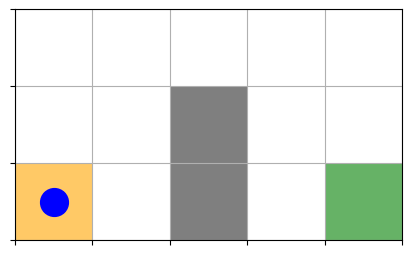

List of actions: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


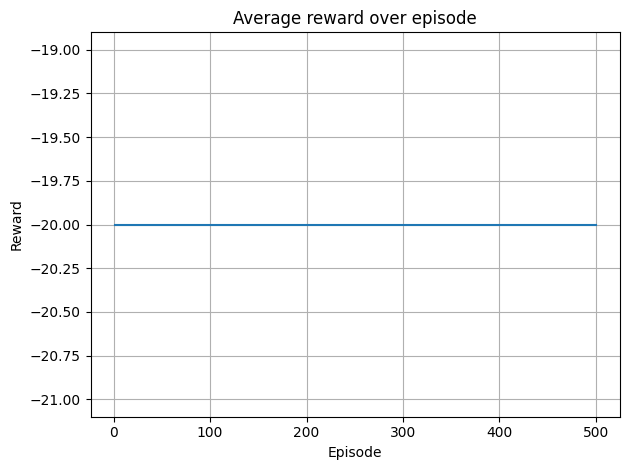

In [41]:
# --- Demo run ---
env = MiniGridWorld()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

n_actions = len(env.ACTIONS)
obs_dim = 2

actor_net = ActorNetwork(n_observations=obs_dim, n_actions=n_actions).to(device)
critic_net = CriticNetwork(n_observations=obs_dim).to(device)

opt_actor  = optim.Adam(actor_net.parameters(),  lr=0.001)
opt_critic = optim.Adam(critic_net.parameters(), lr=0.001)

replay = ReplayBuffer(10000)

episodes = 500
gamma = 0.8
batch_size = 128
global_step = 0

reward_ovt = []
reward_arr = []

pbar = tqdm(range(episodes))

for episode in pbar:
    done = False
    state = env.reset()
    state = env.start
    rewards = 0
    while not done:
        s_vec = state_to_tensor(state, env)
        action = select_action_from_actor(actor_net, s_vec, device, sample=True)
        next_state, reward, done, _ = env.step(action)
        s_next_vec = state_to_tensor(next_state, env)
        replay.push(s_vec, action, reward, s_next_vec, done)
        stats = None
        if episode >= 20:
            stats = train_step_actor_critic(
                actor_net, critic_net, opt_actor, opt_critic, replay,
                batch_size=batch_size, gamma=0.99, entropy_coef=0.01, value_coef=0.5,
                grad_clip_norm=10.0, device=device
            )
        rewards += reward
        state = next_state
        
    reward_arr.append(rewards)
    reward_ovt.append(np.average(reward_arr))

    if stats is not None:
        pbar.set_description(f"Episode {episode + 1}/{episodes} | Reward: {np.average(reward_arr):.2f} | "
              f"Steps: {global_step} | Loss: {stats['loss_actor']+stats['loss_critic']:.3f}")
    else:
        pbar.set_description(f"Warmup Episode {episode + 1}/{episodes} | Reward: {np.average(reward_arr):.2f} | "
              f"Steps: {global_step}")

done = False
_ = env.reset()
env.render_matplotlib()
state = env.start
actions = []
while not done:
    s_vec = state_to_tensor(state, env)
    action = select_action_from_actor(actor_net, s_vec, device, sample=True)
    state, reward, done, _ = env.step(action)
    env.render_matplotlib()
    actions.append(action)

print("List of actions:", actions)

plt.figure()
plt.plot(np.arange(1, episodes + 1), np.array(reward_ovt), linewidth=1.5)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Average reward over episode")
plt.grid(True)
plt.tight_layout()
plt.show()
# print(reward_ovt)

# **References**
https://www.youtube.com/watch?v=VnpRp7ZglfA&list=LL&index=2
